<div style='background-color: rgb(245, 238, 233); padding: 10px;'>
    
---
    
# Stock prediction tool

My main purpose of this project is to create the most accurate classificator, that **will tell whether the price of some stock/cryptocurrency will go up next day or not.** <br><br>
I will evaluate the models on **Bitcoin** data first, create some usefull functions and tools in order to reuse them later on other stocks.<br><br>
After the models will be created, I want to implement them into some sort of application, allowing to get the information about the potential increase.

**I want to include these cryptos inside my app:**

> **Bitcoin** - BTC-USD<br>
> **Ethereum** - ETH-USD<br>
> **BNB** - BNB-USD<br>
> **Dogecoin** - DOGE-USD<br>
---
</div>

In [69]:
import yfinance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, r2_score, roc_auc_score, RocCurveDisplay, classification_report,\
                                confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

from functools import partial

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# Getting the data

I am going to work on Yahoo Stock data, which shows different daily stock prices.

---

</div>

In [2]:
bitcoin = yfinance.Ticker("BTC-USD")
ethereum = yfinance.Ticker("ETH-USD")
bincoin = yfinance.Ticker("BNB-USD")
dogecoin = yfinance.Ticker("DOGE-USD")

currency_names = ["Bitcoin", "Ethereum",
                  "Binance Coin", "Dogecoin"]

currencies_data = [bitcoin.history(period="max"), ethereum.history(period="max"),
                   bincoin.history(period="max"), dogecoin.history(period="max")]

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# Quick look at some cryptocurrencies

As the data is already clean, I will perform **Feature engineering** and **Feature selection**, supported by some analysis.

---
</div>

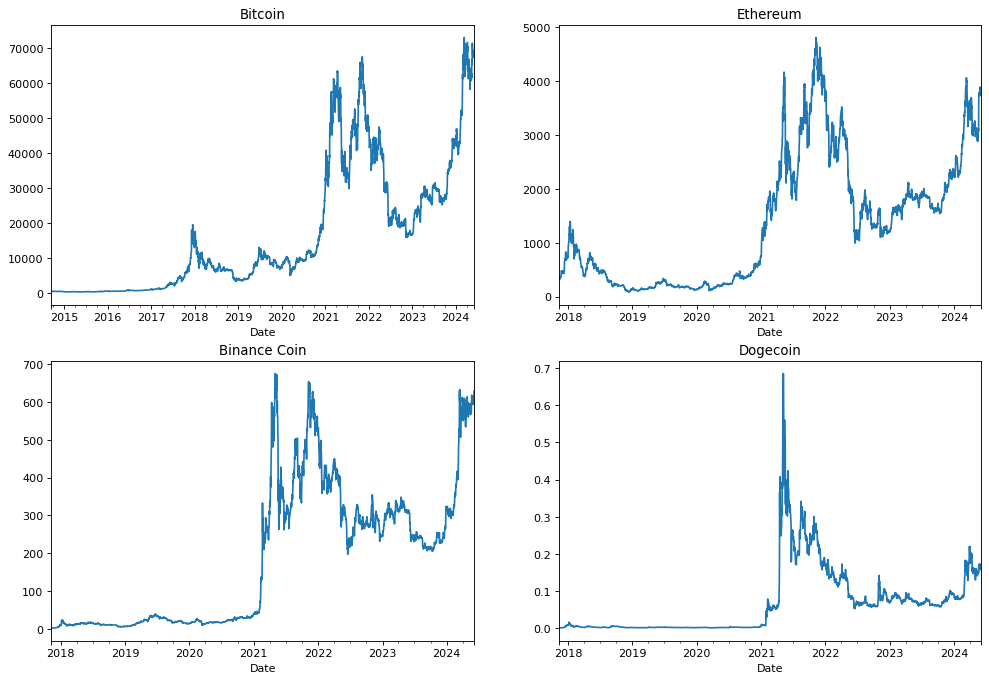

In [3]:
fig, axes = plt.subplots(figsize=(15,10), dpi=80, nrows=2, ncols=2)

for ax, name, data in zip(axes.flatten(), currency_names, currencies_data):
    data["Close"].plot(ax=ax)
    ax.set_title(name)

In [4]:
bitcoin_data = currencies_data[0]
bitcoin_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-31 00:00:00+00:00,68362.515625,68999.562500,66633.421875,67491.414062,27387283769,0.0,0.0
2024-06-01 00:00:00+00:00,67489.609375,67839.765625,67386.195312,67706.937500,11641495604,0.0,0.0
2024-06-02 00:00:00+00:00,67710.273438,68409.164062,67315.523438,67751.601562,17110588415,0.0,0.0


<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Relative Strength Index

Let's create a function that will generate a column for stocks with RSI.

---
</div>

In [5]:
def RSI(data: pd.Series, window: int = 14) -> pd.Series:
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Feature creation

I am going to create following features:

- **Shifted price**
- **Moving average**
- **Exponential Moving average**
- **RSI**<br><br>

---
</div>

In [16]:
past_prices_values = [1, 3, 7, 14, 30, 200]
window_values = [3, 7, 14, 30, 50, 200]

for pp in past_prices_values:
    bitcoin_data[f"{pp}D"] = bitcoin_data["Close"].shift(pp)

for window in window_values:
    # MOVING AVERAGE
    bitcoin_data[f"{window}DA"] = bitcoin_data["Close"].rolling(window=window).mean()
    # EXPONENTIAL MOVING AVERAGE
    bitcoin_data[f"{window}DEA"] = bitcoin_data["Close"].ewm(span=window, adjust=False).mean()
    # RSI
    bitcoin_data[f"{window}RSI"] = RSI(bitcoin_data["Close"].copy(), window=window)

# TARGET VARIABLE
bitcoin_data["Growth"] = (bitcoin_data["Close"] < bitcoin_data["Close"].shift(-1)).astype(int)

bitcoin_data.dropna()[:-1]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,1D,3D,7D,...,30DA,30DEA,30RSI,50DA,50DEA,50RSI,200DA,200DEA,200RSI,Growth
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-05 00:00:00+00:00,253.761002,260.674988,251.942001,260.597992,19649200,0.0,0.0,253.697006,253.005005,242.712997,...,265.654567,257.536366,46.401498,259.639901,258.807999,50.561944,309.859490,306.873610,44.397749,0
2015-04-06 00:00:00+00:00,260.721008,261.798004,254.574997,255.492004,20034200,0.0,0.0,260.597992,254.322006,247.526001,...,264.962268,257.404472,43.892944,260.053241,258.677960,53.768809,309.014750,306.362350,45.111678,0
2015-04-07 00:00:00+00:00,255.274002,255.804993,252.205002,253.179993,18467400,0.0,0.0,255.492004,253.697006,244.223999,...,264.256468,257.131925,43.788641,260.439981,258.462354,53.509247,308.306670,305.833173,45.836650,0
2015-04-08 00:00:00+00:00,253.063995,253.847000,244.214996,245.022003,30086400,0.0,0.0,253.179993,260.597992,247.272003,...,262.770301,256.350639,36.353000,260.468221,257.935281,50.257753,307.487260,305.228086,45.165140,0
2015-04-09 00:00:00+00:00,244.751007,246.117996,239.399994,243.675995,21643500,0.0,0.0,245.022003,255.492004,253.005005,...,261.167501,255.532920,35.208913,260.615221,257.376093,51.371431,306.711535,304.615628,45.399181,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30 00:00:00+00:00,67576.085938,69500.539062,67118.078125,68364.992188,29509712534,0.0,0.0,67578.093750,69394.554688,67929.562500,...,65192.147396,66517.637998,59.384132,64902.850000,65638.603937,48.385851,53975.814473,55410.606933,56.599713,0
2024-05-31 00:00:00+00:00,68362.515625,68999.562500,66633.421875,67491.414062,27387283769,0.0,0.0,68364.992188,68296.218750,68526.101562,...,65500.060807,66580.462261,61.643582,64851.466094,65711.263157,48.143718,54130.759766,55530.813969,56.523126,1
2024-06-01 00:00:00+00:00,67489.609375,67839.765625,67386.195312,67706.937500,11641495604,0.0,0.0,67491.414062,67578.093750,69265.945312,...,65786.177604,66653.138082,61.000696,64861.687500,65789.524896,50.383954,54291.606250,55651.969427,56.792989,1


In [17]:
bitcoin_data = bitcoin_data.dropna()[:-1]
bitcoin_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,1D,3D,7D,...,30DA,30DEA,30RSI,50DA,50DEA,50RSI,200DA,200DEA,200RSI,Growth
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-05 00:00:00+00:00,253.761002,260.674988,251.942001,260.597992,19649200,0.0,0.0,253.697006,253.005005,242.712997,...,265.654567,257.536366,46.401498,259.639901,258.807999,50.561944,309.859490,306.873610,44.397749,0
2015-04-06 00:00:00+00:00,260.721008,261.798004,254.574997,255.492004,20034200,0.0,0.0,260.597992,254.322006,247.526001,...,264.962268,257.404472,43.892944,260.053241,258.677960,53.768809,309.014750,306.362350,45.111678,0
2015-04-07 00:00:00+00:00,255.274002,255.804993,252.205002,253.179993,18467400,0.0,0.0,255.492004,253.697006,244.223999,...,264.256468,257.131925,43.788641,260.439981,258.462354,53.509247,308.306670,305.833173,45.836650,0
2015-04-08 00:00:00+00:00,253.063995,253.847000,244.214996,245.022003,30086400,0.0,0.0,253.179993,260.597992,247.272003,...,262.770301,256.350639,36.353000,260.468221,257.935281,50.257753,307.487260,305.228086,45.165140,0
2015-04-09 00:00:00+00:00,244.751007,246.117996,239.399994,243.675995,21643500,0.0,0.0,245.022003,255.492004,253.005005,...,261.167501,255.532920,35.208913,260.615221,257.376093,51.371431,306.711535,304.615628,45.399181,0


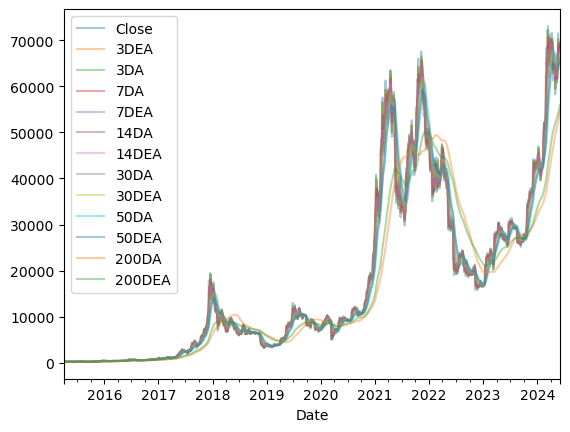

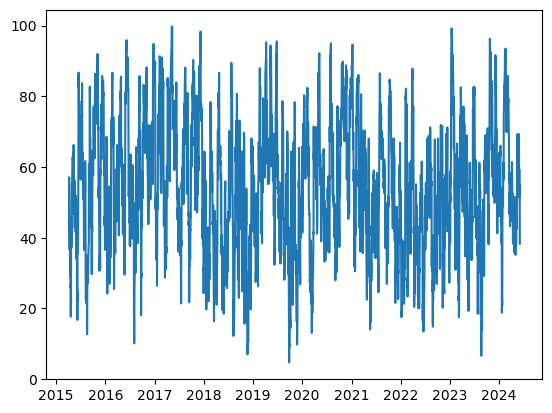

In [18]:
bitcoin_data[["Close", "3DEA", "3DA", "7DA", "7DEA", "14DA", "14DEA", "30DA", "30DEA", "50DA", "50DEA", "200DA", "200DEA"]].plot(alpha=0.4)
plt.show()

plt.plot(bitcoin_data["14RSI"])

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Quick validation function

This function will help evaluate the estimators, where the predictions are made for next 300 days (on default).<br>
It doesn't include the cross-validation, it is just a pure quick test.

---
</div>

In [19]:
features = ["Open", "High", "Low", "Close", "Volume",
            "1D", "3D", "7D", "14D", "30D", "200D",
            "3DA", "7DA", "14DA", "30DA", "50DA", "200DA",
            "3DEA", "7DEA", "14DEA", "30DEA", "50DEA", "200DEA",
            "3RSI", "7RSI", "14RSI", "30RSI", "50RSI", "200RSI"]

def check_model(model, data: pd.DataFrame, features: list, target: str, test_size: int = 300, threshold: float = 0.6):
    X = bitcoin_data[features].values
    y = bitcoin_data[target].values

    n_size = len(X)

    # Train Test Split
    X_train = X[:n_size-test_size, :]
    X_test = X[n_size-test_size:, :]
    
    y_train = y[:n_size-test_size]
    y_test = y[n_size-test_size:]

    # Fitting the model
    model.fit(X_train, y_train)

    # Predicting with a threshold
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred[y_pred > threshold] = 1
    y_pred[y_pred <= threshold] = 0

    # Displaying the results
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.show()


<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### I will start with Random Forest and check it's performance

---
</div>

              precision    recall  f1-score   support

           0       0.47      0.86      0.61       142
           1       0.52      0.14      0.22       158

    accuracy                           0.48       300
   macro avg       0.50      0.50      0.41       300
weighted avg       0.50      0.48      0.40       300



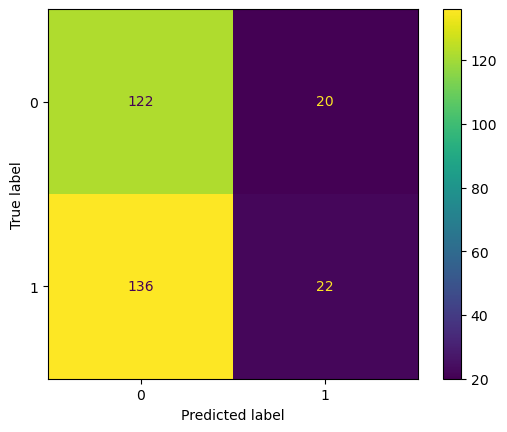

In [20]:
rf = RandomForestClassifier(bootstrap=False)

check_model(rf, bitcoin_data, features, "Growth")

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Feature selection

I will perform feature selection based on different methods:

- **Random Forest feature importances**
- **Recursive Feature Elimination**

---
</div>

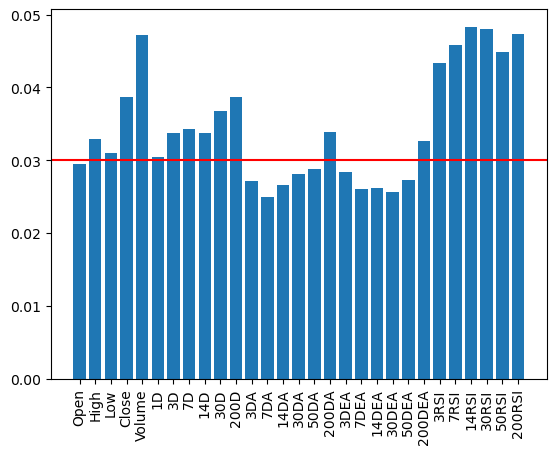

In [46]:
plt.bar(range(1, len(features)+1), rf.feature_importances_)
plt.axhline(0.03, c='r')
plt.xticks(range(1, len(features)+1), features)
plt.xticks(rotation=90)
plt.show()

In [22]:
rfe = RFE(RandomForestClassifier())
rfe.fit(bitcoin_data[features], bitcoin_data["Growth"])

RFE(estimator=RandomForestClassifier())

In [23]:
features_rfe = list(np.array(features)[rfe.ranking_ == 1])

In [51]:
features_rfe

['Close',
 'Volume',
 '3D',
 '7D',
 '14D',
 '30D',
 '200D',
 '200DA',
 '3RSI',
 '7RSI',
 '14RSI',
 '30RSI',
 '50RSI',
 '200RSI']

              precision    recall  f1-score   support

           0       0.46      0.87      0.60       142
           1       0.37      0.07      0.12       158

    accuracy                           0.45       300
   macro avg       0.41      0.47      0.36       300
weighted avg       0.41      0.45      0.34       300



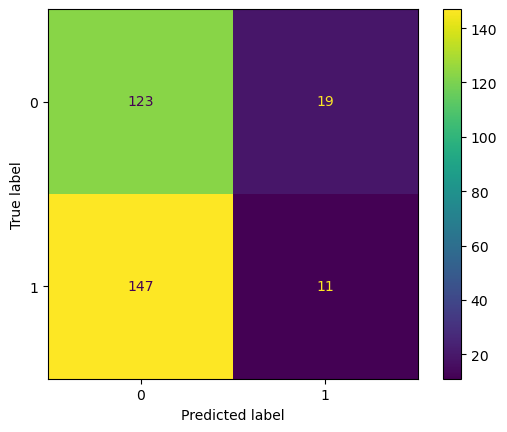

In [47]:
features_cut = ["High", "Close", "Volume", "1D", "3D", "7D", "30D", "200D", "200DA", "200DEA", "3RSI", "7RSI", "14RSI", "30RSI", "50RSI", "200RSI"]

rf_cut = RandomForestClassifier()
check_model(rf_cut, bitcoin_data, features_rfe, "Growth")

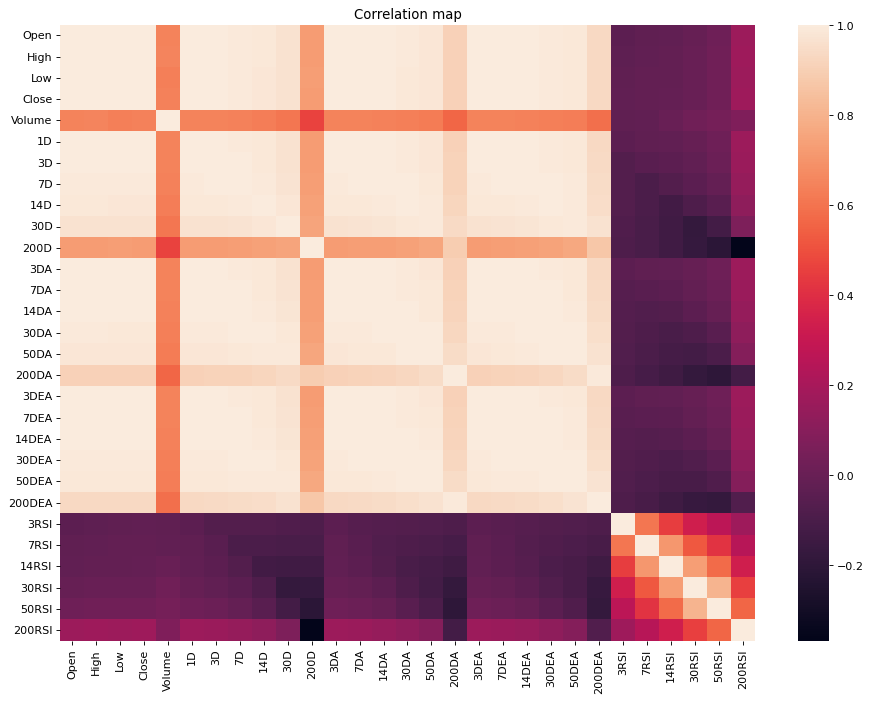

In [25]:
plt.figure(figsize=(14,10), dpi=80)
sns.heatmap(bitcoin_data[features].corr())
plt.title("Correlation map")
plt.show()

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### It's time to evaluate models with some more reliable methods

I will use **TimeSeriesSplit** class to perform cross-validation on the data.

---
</div>

In [98]:
splitter = TimeSeriesSplit(n_splits=5)
splitter2 = TimeSeriesSplit(max_train_size=500, test_size=1, n_splits=5)

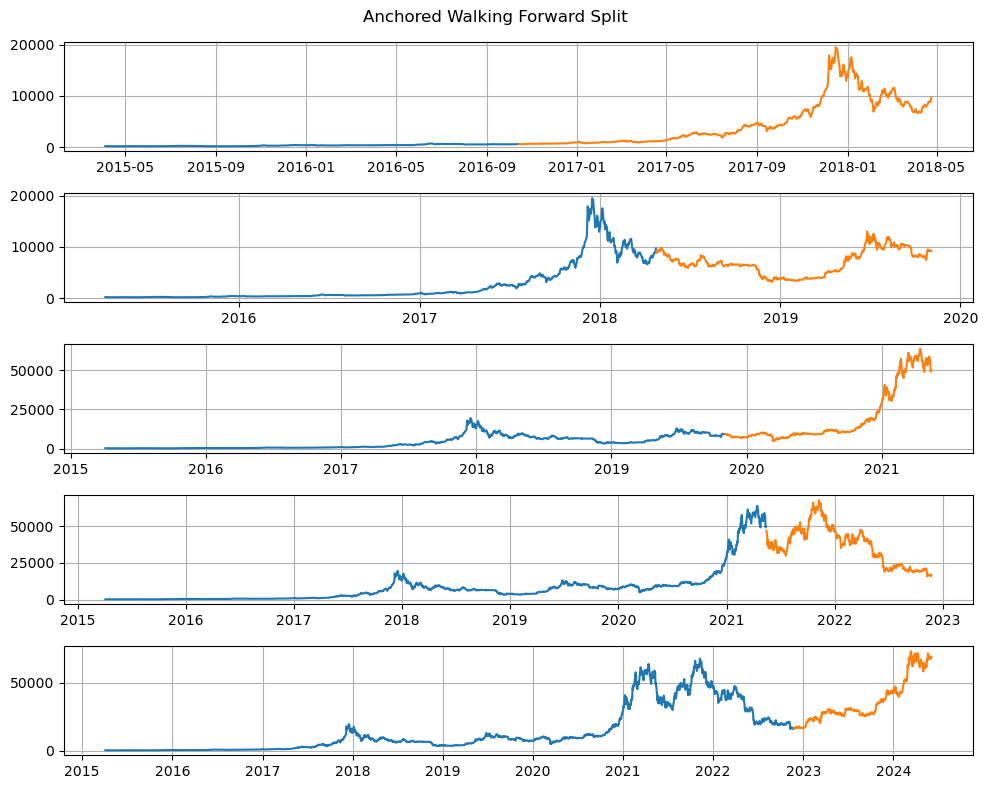

In [104]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=5)

for ax, (x_s, t_s) in zip(axes.flatten(), splitter.split(bitcoin_data)):
    data_part_train = bitcoin_data.iloc[x_s, :]
    data_part_test = bitcoin_data.iloc[t_s, :]
    ax.plot(data_part_train["Close"])
    ax.plot(data_part_test["Close"])
    ax.grid()
fig.suptitle("Anchored Walking Forward Split")
plt.tight_layout()

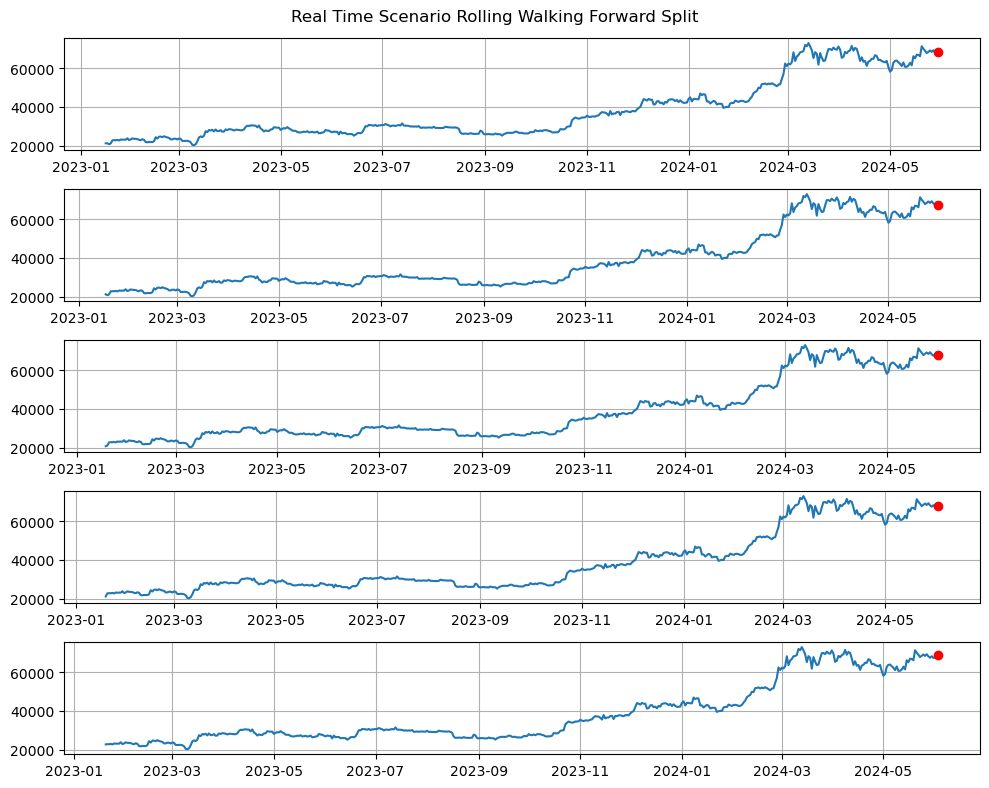

In [106]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=5)

for ax, (x_s, t_s) in zip(axes.flatten(), splitter2.split(bitcoin_data)):
    data_part_train = bitcoin_data.iloc[x_s, :]
    data_part_test = bitcoin_data.iloc[t_s, :]
    ax.plot(data_part_train["Close"])
    ax.plot(data_part_test["Close"], "ro")
    ax.grid()
fig.suptitle("Real Time Scenario Rolling Walking Forward Split")
plt.tight_layout()

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Let's create some useful functions

These functions will be a more flexible tool to check the models, including the threshold for probabilities and different **Walk Forward** methods.

---
</div>

In [118]:
def prediction_scorer_threshold(model, X: np.ndarray, y: np.ndarray, threshold: float = 0.6, scoring=precision_score) -> float:
    """
    Calculates the given metric, classifing the class 1 under the condition of exceeding the given probability threshold..
    """
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob > threshold).astype(int)

    return scoring(y, y_pred, pos_label=1, zero_division=0)
    

def check_model_awf(model, X: np.ndarray, y: np.ndarray, splits: int = 5, threshold: float = 0.6) -> float:
    """
    Cross-validates the Time Series data with Anchored Walking Forward approach.
    """
    cvts = TimeSeriesSplit(n_splits=splits)
    output = cross_validate(model, X, y, cv=cvts, scoring={"Precision": partial(prediction_scorer_threshold, threshold=threshold),
                                                           "Recall": partial(prediction_scorer_threshold, threshold=threshold, scoring=recall_score)})

    return np.mean(output["test_Precision"]), np.mean(output["test_Recall"])


def check_model_rwf(model, X: np.ndarray, y: np.ndarray, max_train_size: int = 500, test_size: int = 100, threshold: float = 0.6) -> float:
    """
    Cross-validates the Time Series data with Rolling Walking Forward approach.
    """
    splits = (len(X)-max_train_size)//test_size
    cvts = TimeSeriesSplit(n_splits=splits, max_train_size=max_train_size, test_size=test_size)
    output = cross_validate(model, X, y, cv=cvts, scoring={"Precision": partial(prediction_scorer_threshold, threshold=threshold),
                                                           "Recall": partial(prediction_scorer_threshold, threshold=threshold, scoring=recall_score)})

    return np.mean(output["test_Precision"]), np.mean(output["test_Recall"])


def find_best_threshold(model, X: np.ndarray, y: np.ndarray, min_threshold: float = 0.5, max_threshold: float = 0.6, step: float = 0.01,
                                                             awf_splits: int = 5, rwf_max_train_size: int = 500, rwf_test_size: int = 100) -> None:
    """
    Prints the model performance with both - anchored and rolling walking forward CVs, for different thresholds.
    """
    
    for thr in np.arange(min_threshold, max_threshold+step, step):
        a_precision, a_recall = check_model_awf(model, X, y, splits=awf_splits, threshold=thr)
        r_precision, r_recall = check_model_rwf(model, X, y, max_train_size=rwf_max_train_size, test_size=rwf_test_size, threshold=thr)
        print(f"-*-*- THRESHOLD = {round(thr, 2)} -*-*-")
        print(f"ANCHORED --- | PRECISION = {a_precision} | RECALL = {a_recall}")
        print(f"ROLLING --- | PRECISION = {r_precision} | RECALL = {r_recall}")
        print("\n\n")

In [48]:
Xf = bitcoin_data[features].values
yf = bitcoin_data["Growth"].values

Xfc = bitcoin_data[features_cut].values
yfc = bitcoin_data["Growth"].values

Xfr = bitcoin_data[features_rfe].values
yfr = bitcoin_data["Growth"].values

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---

# Searching for the best threshold

I will use threshold of **0.53** for **Random Forest**.

---
</div>

In [117]:
find_best_threshold(RandomForestClassifier(), Xfr, yfr, awf_splits=20, max_threshold=0.58)

-*-*- THRESHOLD = 0.5 -*-*-
ANCHORED --- | PRECISION = 0.532658775074193 | RECALL = 0.43385853074480096
ROLLING --- | PRECISION = 0.5445711133676571 | RECALL = 0.5210331165881202



-*-*- THRESHOLD = 0.51 -*-*-
ANCHORED --- | PRECISION = 0.5326571157620454 | RECALL = 0.43756461072979647
ROLLING --- | PRECISION = 0.5135376886851416 | RECALL = 0.48998683694694156



-*-*- THRESHOLD = 0.52 -*-*-
ANCHORED --- | PRECISION = 0.5585641942133364 | RECALL = 0.41825984094041757
ROLLING --- | PRECISION = 0.5088590680418792 | RECALL = 0.44048321641285526



-*-*- THRESHOLD = 0.53 -*-*-
ANCHORED --- | PRECISION = 0.5854222590344302 | RECALL = 0.3555272061064691
ROLLING --- | PRECISION = 0.5378956408851028 | RECALL = 0.43004626189292783



-*-*- THRESHOLD = 0.54 -*-*-
ANCHORED --- | PRECISION = 0.551817099615355 | RECALL = 0.33058774361981036
ROLLING --- | PRECISION = 0.5343465790097573 | RECALL = 0.3884608994492545



-*-*- THRESHOLD = 0.55 -*-*-
ANCHORED --- | PRECISION = 0.5458918738452285 | RECA

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---

# Let's run the test once again

But this time look what features do the best.

---
</div>

In [120]:
titles = ["All features", "Features picked by rf importances", "Features picked by RFE"]
for name, (X, y) in zip(titles, [(Xf, yf), (Xfc, yfc), (Xfr, yfr)]):
    aw_precision, aw_recall = check_model_awf(rf, Xf, yf, splits=10, threshold=0.53)
    rw_precision, rw_recall = check_model_rwf(rf, Xf, yf, threshold=0.53)

    
    
    print(f"--- --- --- --- --- --- {name} --- --- --- --- --- ---")
    print("--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---")
    print(f"Precision: {aw_precision} | Recall: {aw_recall}")
    print("--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---")
    print(f"Precision: {rw_precision} | Recall: {rw_recall}")
    print("\n\n\n")

--- --- --- --- --- --- All features --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
Precision: 0.5707885179499232 | Recall: 0.33472302439976687
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
Precision: 0.5476599140606092 | Recall: 0.42083510094934923




--- --- --- --- --- --- Features picked by rf importances --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
Precision: 0.6519586147229073 | Recall: 0.318737007774221
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
Precision: 0.5391140610162849 | Recall: 0.4324616080400766




--- --- --- --- --- --- Features picked by RFE --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
Precision: 0.5801942678760976 | Recall: 0.33547720492217115
--- --- --- Raw Random Forest Rol

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Real Time Scenario cross validation

This function simply simulates the actual work that will be done by the classificators.

---
</div>

In [121]:
def cross_validate_rts(model, X, y, threshold=0.6):
    """
    Creates a Real-Time-Scenario backtesting cross-validation.
    """
    n_rows = len(X)
    cv = TimeSeriesSplit(max_train_size=n_rows-150, test_size=1, n_splits=150)
    y_test = []
    y_pred = []
    for train_id, test_id in cv.split(X):
        model.fit(X[train_id], y[train_id])
        y_prob = model.predict_proba(X[test_id])[:,1]
        y_pred.append(y_prob > threshold)
        y_test.append(y[test_id])
    return np.ravel(np.array(y_test)), np.ravel(np.array(y_pred))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
## Real-time-scenario for pure Random Forest estimator

---
</div>

In [122]:
res = cross_validate_rts(RandomForestClassifier(bootstrap=False), Xfr, yfr, threshold=0.53)

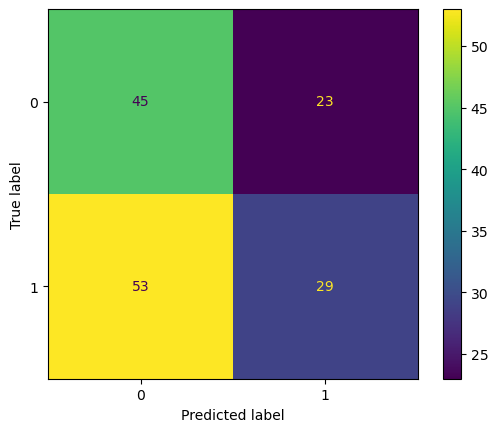

              precision    recall  f1-score   support

           0       0.46      0.66      0.54        68
           1       0.56      0.35      0.43        82

    accuracy                           0.49       150
   macro avg       0.51      0.51      0.49       150
weighted avg       0.51      0.49      0.48       150



In [123]:
yt, yp = res
ConfusionMatrixDisplay(confusion_matrix(np.ravel(yt), np.ravel(yp))).plot()
plt.show()
print(classification_report(np.ravel(yt), np.ravel(yp)))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---

# Creating the train and test dataset

I will create the data based on features evaluated by RFE. I will also create scaled version of the data for SVM.

---
</div>

In [124]:
scaler = MinMaxScaler()

X_train = Xfr[:3000]
X_test = Xfr[3000:]

y_train = yfr[:3000]
y_test = yfr[3000:]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(Xfr)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Hyperparams tuning - 1st run

**Params:**

- max_depth: 6
- n_estimators: 100

**Precision:** 0.584<br>
**Recall**: 0.382

---
</div>

In [125]:
params = {
    "max_depth": [6, 8, 12, 16, 20],
    "n_estimators": [100, 200, 300]
}

rf_cv = GridSearchCV(RandomForestClassifier(bootstrap=False),
                     params,
                     cv=TimeSeriesSplit(n_splits=20), 
                     scoring=partial(prediction_scorer_threshold, scoring=precision_score, threshold=0.53),
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=RandomForestClassifier(bootstrap=False), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 12, 16, 20],
                         'n_estimators': [100, 200, 300]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, scoring=<function precision_score at 0x00000298C321AB60>, threshold=0.53))

In [132]:
print(rf_cv.best_params_)
print(rf_cv.best_score_)

check_model_awf(rf_cv.best_estimator_, X_train, y_train, threshold=0.53, splits=50)

{'max_depth': 6, 'n_estimators': 100}
0.5838982880589695


(0.5792459355394293, 0.3817741610595059)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### 2nd run
It got worse

**Params**:

- max_depth: 4
- n_estimators: 100

**Precision:** 0.539<br>
**Recall**: 0.346

---
</div>

In [130]:
params = {
    "max_depth": [4, 5, 6, 7],
    "n_estimators": [100, 120, 150, 170]
}

rf_cv2 = GridSearchCV(RandomForestClassifier(bootstrap=False),
                     params,
                     cv=TimeSeriesSplit(n_splits=20), 
                     scoring=partial(prediction_scorer_threshold, scoring=precision_score, threshold=0.53),
                     n_jobs=-1)

rf_cv2.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=RandomForestClassifier(bootstrap=False), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'n_estimators': [100, 120, 150, 170]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, scoring=<function precision_score at 0x00000298C321AB60>, threshold=0.53))

In [133]:
print(rf_cv2.best_params_)
print(rf_cv2.best_score_)

check_model_awf(rf_cv2.best_estimator_, X_train, y_train, threshold=0.53, splits=50)

{'max_depth': 4, 'n_estimators': 100}
0.5777617711499249


(0.5387903377390453, 0.3463542369407322)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
## Checking the best Random Forest estimator in real-time-scenario

It gave the wrong "buy" decision only 3 times, however missess about 70% of opportunities.<br>
It's not bad, however it is also not perfect.

---
</div>

In [134]:
rf_best = RandomForestClassifier(bootstrap=False, max_depth=6, n_estimators=100)

rfb_res = cross_validate_rts(rf_best, Xfr, yfr, threshold=0.53)

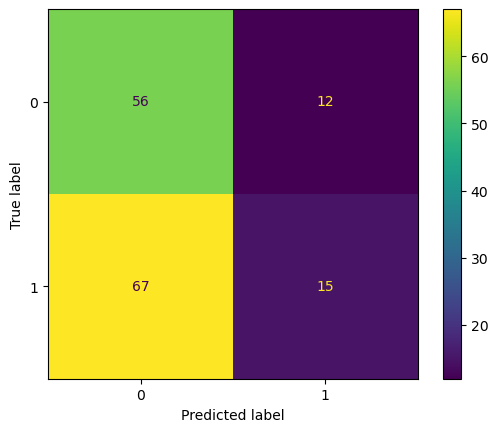

              precision    recall  f1-score   support

           0       0.46      0.82      0.59        68
           1       0.56      0.18      0.28        82

    accuracy                           0.47       150
   macro avg       0.51      0.50      0.43       150
weighted avg       0.51      0.47      0.42       150



In [135]:
yt, yp = rfb_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# Support Vector Machines

Now let's check how the **SVM** will do with this problem.<br>
I am going to pick threshold of **0.52** for **SVM**.<br>
<br>
Another thing, that I have noticed is the time it takes SVM and RF to train and predict. It is way better in terms of SVM.

---
</div>

In [136]:
find_best_threshold(SVC(probability=True), X_train_scaled, y_train, awf_splits=20, max_threshold=0.58)

-*-*- THRESHOLD = 0.5 -*-*-
ANCHORED --- | PRECISION = 0.5379595659921294 | RECALL = 0.9561364704625573
ROLLING --- | PRECISION = 0.5105645018969741 | RECALL = 0.7474927395918616



-*-*- THRESHOLD = 0.51 -*-*-
ANCHORED --- | PRECISION = 0.5390832152301641 | RECALL = 0.9696989459815546
ROLLING --- | PRECISION = 0.49378415300256817 | RECALL = 0.7212954082847728



-*-*- THRESHOLD = 0.52 -*-*-
ANCHORED --- | PRECISION = 0.540516059069891 | RECALL = 0.9169323916546916
ROLLING --- | PRECISION = 0.4900331602125836 | RECALL = 0.5971765850211951



-*-*- THRESHOLD = 0.53 -*-*-
ANCHORED --- | PRECISION = 0.5392814531865929 | RECALL = 0.8540817998195278
ROLLING --- | PRECISION = 0.4655962850552065 | RECALL = 0.5352287408004318



-*-*- THRESHOLD = 0.54 -*-*-
ANCHORED --- | PRECISION = 0.5562896699606555 | RECALL = 0.7465617158850957
ROLLING --- | PRECISION = 0.4025006646600475 | RECALL = 0.4560207271737414



-*-*- THRESHOLD = 0.55 -*-*-
ANCHORED --- | PRECISION = 0.5318490626779352 | RECALL = 

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---


# Let's run it once again



---
</div>

In [137]:
aw_precision, aw_recall = check_model_awf(SVC(probability=True), X_train_scaled, y_train, splits=20, threshold=0.52)
rw_precision, rw_recall = check_model_rwf(SVC(probability=True), X_train_scaled, y_train, threshold=0.52)
   
print("--- --- --- --- --- --- SVC --- --- --- --- --- ---")
print("--- --- --- Raw SVC Anchored Walking Forward Cross-validation Score --- --- ---")
print(f"Precision: {aw_precision} | Recall: {aw_recall}")
print("--- --- --- Raw SVC Rolling Walking Forward Cross-validation Score --- --- ---")
print(f"Precision: {rw_precision} | Recall: {rw_recall}")
print("\n\n\n")

--- --- --- --- --- --- SVC --- --- --- --- --- ---
--- --- --- Raw SVC Anchored Walking Forward Cross-validation Score --- --- ---
Precision: 0.5381318610823993 | Recall: 0.9233712705194025
--- --- --- Raw SVC Rolling Walking Forward Cross-validation Score --- --- ---
Precision: 0.48443033828916177 | Recall: 0.5583413476147545






---

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---


# Quite low precision, but high recall

Let's try to optimize precision for this given threshold.



---
</div>

In [138]:
params = {
    "C": [1, 10, 50, 100, 200, 300],
    "gamma": [1, 0.1, 0.001, 0.0001],
    "kernel": ["linear", "rbf"]
}

svm_cv = GridSearchCV(SVC(probability=True),
                     params,
                     cv=TimeSeriesSplit(n_splits=20), 
                     scoring=partial(prediction_scorer_threshold, threshold=0.52),
                     n_jobs=-1)

svm_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 200, 300],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, threshold=0.52))

In [140]:
print(svm_cv.best_score_)
print(svm_cv.best_params_)

check_model_awf(svm_cv.best_estimator_, X_train_scaled, y_train, splits=50, threshold=0.52)

0.5460742295882749
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


(0.5397811598561266, 0.9099445531939239)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### 2nd run

**Params**:

- C: 5
- gamma: 1
- kernel: rbf

**Precision:** 0.543<br>
**Recall:** 0.878

---
</div>

In [141]:
params = {
    "C": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    "gamma": [1, 0.9, 0.8]
}

svm_cv2 = GridSearchCV(SVC(kernel="rbf", probability=True),
                     params,
                     cv=TimeSeriesSplit(n_splits=20), 
                     scoring=partial(prediction_scorer_threshold, threshold=0.52),
                     n_jobs=-1)

svm_cv2.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'gamma': [1, 0.9, 0.8]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, threshold=0.52))

In [143]:
print(svm_cv2.best_score_)
print(svm_cv2.best_params_)

check_model_awf(svm_cv2.best_estimator_, X_train_scaled, y_train, splits=50, threshold=0.52)

0.547640356030299
{'C': 5, 'gamma': 1}


(0.542977770391299, 0.8780705340450088)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### WARNING!!!

LONG TIME OF EXECUTION

---
</div>

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Evaluation on Real-Time-Scenario

I will evaluate on anchored version, however there is a function for a rolling one.

---
</div>

In [144]:
def cross_validate_rts_na(model: object, X: np.array, y: np.array, threshold: float = 0.6, n_days: int = 150): # non anchored
    cv = TimeSeriesSplit(max_train_size=500, test_size=1, n_splits=n_days)
    y_test = []
    y_pred = []
    for train_id, test_id in cv.split(X):
        model.fit(X[train_id], y[train_id])
        y_prob = model.predict_proba(X[test_id])[:,1]
        y_pred.append(y_prob > threshold)
        y_test.append(y[test_id])
    return np.ravel(np.array(y_test)), np.ravel(np.array(y_pred))

In [145]:
svm_best = svm_cv2.best_estimator_
svm_res = cross_validate_rts(svm_best, X_scaled, yfr, threshold=0.52)

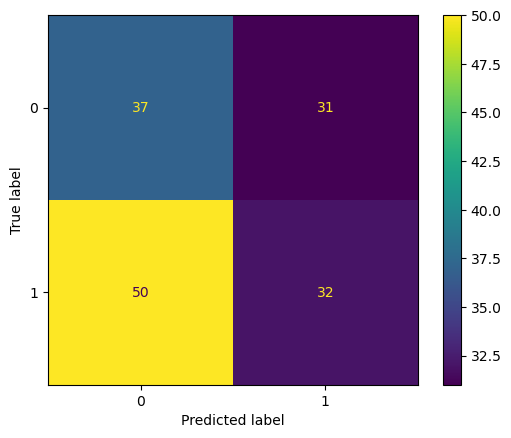

              precision    recall  f1-score   support

           0       0.43      0.54      0.48        68
           1       0.51      0.39      0.44        82

    accuracy                           0.46       150
   macro avg       0.47      0.47      0.46       150
weighted avg       0.47      0.46      0.46       150



In [146]:
yt, yp = svm_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# AdaBoost

The best threshold seems to be 0.5

---
</div>

In [148]:
find_best_threshold(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train, awf_splits=20, max_threshold=0.58)

-*-*- THRESHOLD = 0.5 -*-*-
ANCHORED --- | PRECISION = 0.5419278475468022 | RECALL = 0.649942146650335
ROLLING --- | PRECISION = 0.48629684646601207 | RECALL = 0.5163753966122855



-*-*- THRESHOLD = 0.51 -*-*-
ANCHORED --- | PRECISION = 0.5339378480695933 | RECALL = 0.6014603628137125
ROLLING --- | PRECISION = 0.47943893413077504 | RECALL = 0.4895542037475659



-*-*- THRESHOLD = 0.52 -*-*-
ANCHORED --- | PRECISION = 0.5121416288178233 | RECALL = 0.4744319043718369
ROLLING --- | PRECISION = 0.48975184126981813 | RECALL = 0.45030119093773147



-*-*- THRESHOLD = 0.53 -*-*-
ANCHORED --- | PRECISION = 0.47875398900394617 | RECALL = 0.3512583011262852
ROLLING --- | PRECISION = 0.4541967034373615 | RECALL = 0.382878766177618



-*-*- THRESHOLD = 0.54 -*-*-
ANCHORED --- | PRECISION = 0.44633235662825177 | RECALL = 0.3125439221989245
ROLLING --- | PRECISION = 0.4219007587728939 | RECALL = 0.3614803346543259



-*-*- THRESHOLD = 0.55 -*-*-
ANCHORED --- | PRECISION = 0.38550678572468233 | RECA

In [149]:
print("--- --- --- --- --- --- AdaBoost --- --- --- --- --- ---")
print("--- --- --- Raw AdaBoost Anchored Walking Forward Cross-validation Score --- --- ---")
print(check_model_awf(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train, splits=20, threshold=0.5))
print("--- --- --- Raw AdaBoost Rolling Walking Forward Cross-validation Score --- --- ---")
print(check_model_rwf(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train, threshold=0.5))
print("\n\n\n")

--- --- --- --- --- --- AdaBoost --- --- --- --- --- ---
--- --- --- Raw AdaBoost Anchored Walking Forward Cross-validation Score --- --- ---
(0.5419278475468022, 0.649942146650335)
--- --- --- Raw AdaBoost Rolling Walking Forward Cross-validation Score --- --- ---
(0.48629684646601207, 0.5163753966122855)






<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### AdaBoost in RTS

It gives **62% precision**, but with only **40% of recall**.

---
</div>

In [150]:
ada_res = cross_validate_rts(AdaBoostClassifier(algorithm="SAMME"), Xfr, yfr, threshold=0.5)

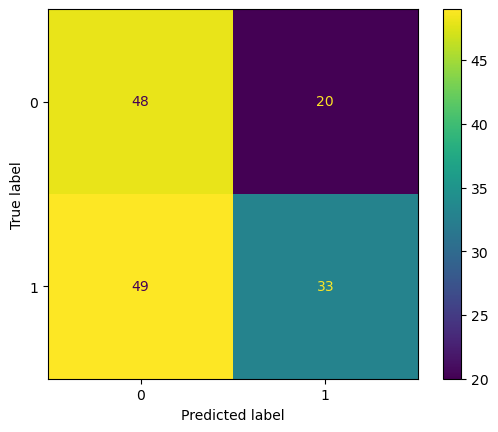

              precision    recall  f1-score   support

           0       0.49      0.71      0.58        68
           1       0.62      0.40      0.49        82

    accuracy                           0.54       150
   macro avg       0.56      0.55      0.54       150
weighted avg       0.56      0.54      0.53       150



In [151]:
yt, yp = ada_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# AdaBoost hypertuning

There is not much to change in terms of this estimator, however it can serve as an **ultimate agreement** in terms of decision (additional confirmation).

---
</div>

In [156]:
params = {
    "n_estimators": [250, 300, 350, 400, 450, 500],
    "learning_rate": [1, 0.7, 0.8, 0.9]
}

ada_cv = GridSearchCV(AdaBoostClassifier(algorithm="SAMME"),
                      params,
                      cv=TimeSeriesSplit(n_splits=30),
                      scoring=partial(prediction_scorer_threshold, scoring=precision_score, threshold=0.5),
                      n_jobs=-1)

ada_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=30, test_size=None),
             estimator=AdaBoostClassifier(algorithm='SAMME'), n_jobs=-1,
             param_grid={'learning_rate': [1, 0.7, 0.8, 0.9],
                         'n_estimators': [250, 300, 350, 400, 450, 500]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x00000298DC178B80>, scoring=<function precision_score at 0x00000298C321AB60>, threshold=0.5))

In [158]:
print(ada_cv.best_params_)
print(ada_cv.best_score_)

check_model_awf(ada_cv.best_estimator_, X_train, y_train, splits=50, threshold=0.5)

{'learning_rate': 1, 'n_estimators': 500}
0.5588901141343567


(0.5636848659518818, 0.5277017010512385)

In [159]:
ada_best = ada_cv.best_estimator_
ada_res = cross_validate_rts(ada_best, Xfr, yfr, threshold=0.5)

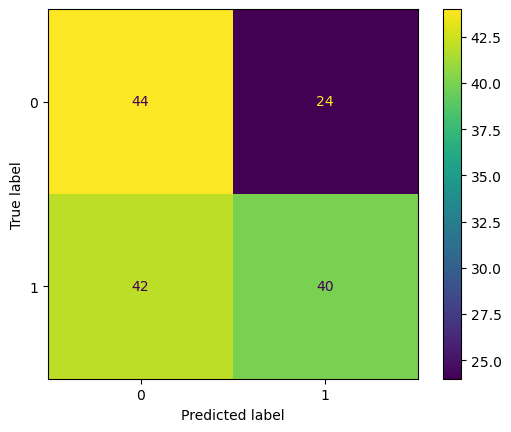

              precision    recall  f1-score   support

           0       0.51      0.65      0.57        68
           1       0.62      0.49      0.55        82

    accuracy                           0.56       150
   macro avg       0.57      0.57      0.56       150
weighted avg       0.57      0.56      0.56       150



In [160]:
yt, yp = ada_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# GradientBoost

Let's start with RTS cross-validation.<br>
It looks like it has potential and I can go with further optimalization.

---
</div>

In [63]:
gb_res = cross_validate_rts(GradientBoostingClassifier(), Xfc, yfc)

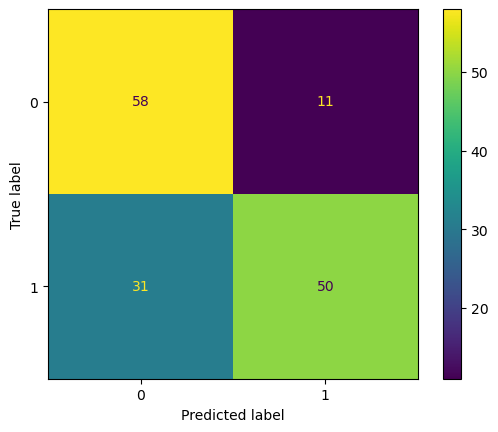

              precision    recall  f1-score   support

           0       0.65      0.84      0.73        69
           1       0.82      0.62      0.70        81

    accuracy                           0.72       150
   macro avg       0.74      0.73      0.72       150
weighted avg       0.74      0.72      0.72       150



In [64]:
yt, yp = gb_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### Hypertuning - 1st run

---
</div>


In [66]:
params = {
    "learning_rate": [0.1, 0.2, 0.3, 0.4],
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [3, 5, 7, 9]
}

gb_cv = GridSearchCV(GradientBoostingClassifier(), 
                     params,
                     cv=TimeSeriesSplit(n_splits=10),
                     scoring=prediction_scorer_threshold,
                     n_jobs=-1)

gb_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 200, 300, 400]},
             scoring=<function prediction_scorer_threshold at 0x000001B7807F5940>)

In [67]:
print(gb_cv.best_params_)
print(gb_cv.best_score_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.8135644618927353


<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### 2nd run

**Params**:

- learning_rate: **0.05**
- max_depth: **3**
- n_estimators: **100**

---
</div>

In [69]:
params = {
    "learning_rate": [0.05, 0.1, 0.15],
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 4, 5]
}

gb_cv2 = GridSearchCV(GradientBoostingClassifier(), 
                     params,
                     cv=TimeSeriesSplit(n_splits=10),
                     scoring=prediction_scorer_threshold,
                     n_jobs=-1)

gb_cv2.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             scoring=<function prediction_scorer_threshold at 0x000001B7807F5940>)

In [70]:
print(gb_cv2.best_params_)
print(gb_cv2.best_score_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.8355044605310924


<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### 3rd run

**Params:**

- learning_rate: **0.04**
- max_depth: **3**
- n_estimators: **110**

---
</div>

In [73]:
params = {
    "learning_rate": [0.03, 0.04, 0.05],
    "n_estimators": [100, 110, 120, 130, 140],
    "max_depth": [3, 4]
}

gb_cv3 = GridSearchCV(GradientBoostingClassifier(), 
                     params,
                     cv=TimeSeriesSplit(n_splits=10),
                     scoring=prediction_scorer_threshold,
                     n_jobs=-1)

gb_cv3.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.04, 0.05],
                         'max_depth': [3, 4],
                         'n_estimators': [100, 110, 120, 130, 140]},
             scoring=<function prediction_scorer_threshold at 0x000001B7807F5940>)

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
### RTS check for GradientBoost
This model performs well, however it is nothing compared to SVM.<br>
Either way, I am going also include it inside the final predictors list.

---
</div>

In [74]:
print(gb_cv3.best_params_)
print(gb_cv3.best_score_)

{'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 110}
0.8448473516401375


In [75]:
gb_best = gb_cv3.best_estimator_
gb_res = cross_validate_rts(gb_best, Xfc, yfc)

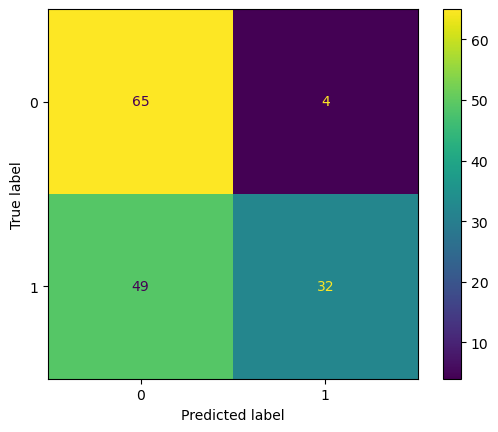

              precision    recall  f1-score   support

           0       0.57      0.94      0.71        69
           1       0.89      0.40      0.55        81

    accuracy                           0.65       150
   macro avg       0.73      0.67      0.63       150
weighted avg       0.74      0.65      0.62       150



In [76]:
yt, yp = gb_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

<div style='background-color: rgb(245, 238, 233); padding: 10px;'>

---
# ToDo
3. LSTM
4. Various ML algorythms
5. River - online learning

---
</div>